# Importación de librerias a manejar

In [1]:
import empiricaldist
#import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import warnings

#Quitar advertencias en los codigos
warnings.filterwarnings('ignore')

# Ver Datasets completos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.options.display.float_format = '{:.2f}'.format

# Importación de datos y Exploración de datos

In [2]:
df_train = pd.read_csv('data\\train_data.csv') # Caracteristicas de los productos  recomendaciones y la indicación del usuario
df_test = pd.read_csv('data\\test_challengue.csv') # Test Prueba

In [3]:
# Entendiendo la composición de los datos

print("Train  Cantidad tipo variables")
print("--------------------------------")
t_1= (
    df_train
    .dtypes
    .value_counts()
)
print(t_1)
print("--------------------------------")
print("Test | Prueba")
t_2 = (
    df_test
    .dtypes
    .value_counts()
)
print("--------------------------------")
print(t_2)
print("--------------------------------")
print("Observaciones df_train {}:".format(str(df_train.shape)))
print("Observaciones df_test {}:".format(str(df_test.shape)))

Train  Cantidad tipo variables
--------------------------------
object     10
float64     8
int64       3
bool        1
dtype: int64
--------------------------------
Test | Prueba
--------------------------------
object     10
float64     8
int64       3
dtype: int64
--------------------------------
Observaciones df_train (60430, 22):
Observaciones df_test (6714, 21):


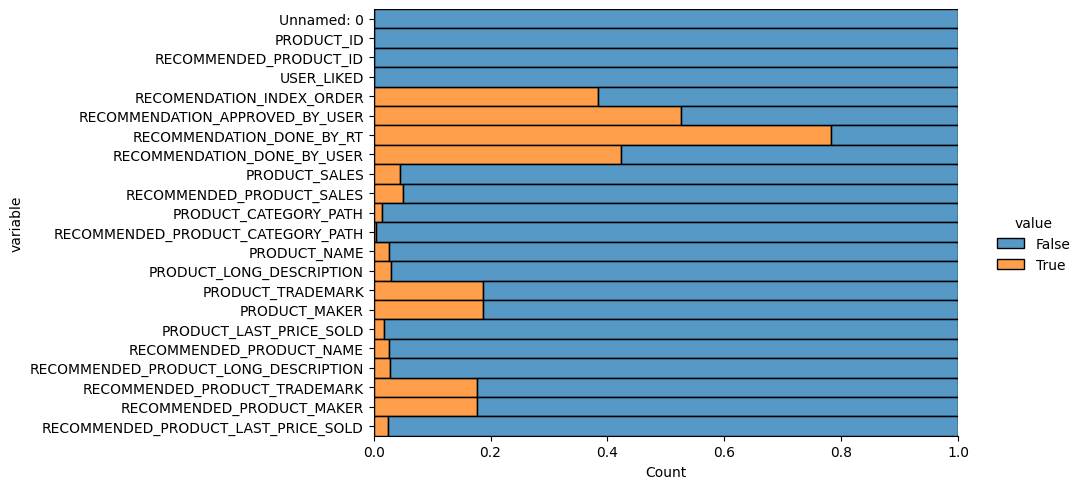

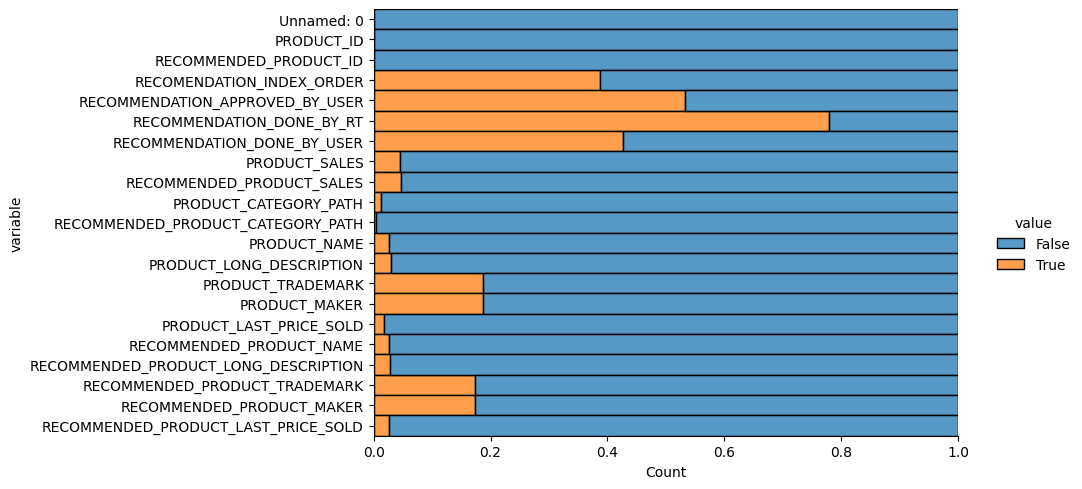

In [4]:
# Proporcion de Nulos en los datos

(
    df_train
    .isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(
                data = df,
                y='variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

(
    df_test
    .isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(
                data = df,
                y='variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

# Análisis descriptivos

In [5]:
# df_test.astype({'PRODUCT_NAME':'category',
#                 'PRODUCT_TRADEMARK':'category',
#                 'PRODUCT_MAKER':'category',
#                 'RECOMMENDED_PRODUCT_NAME':'category',
#                 'RECOMMENDED_PRODUCT_TRADEMARK':'category',
#                 'RECOMMENDED_PRODUCT_MAKER':'category'}). describe(include='category')

df_train.astype({'PRODUCT_NAME':'category',
                'PRODUCT_TRADEMARK':'category',
                'PRODUCT_MAKER':'category',
                'RECOMMENDED_PRODUCT_NAME':'category',
                'RECOMMENDED_PRODUCT_TRADEMARK':'category',
                'RECOMMENDED_PRODUCT_MAKER':'category',
                'USER_LIKED':'category'}). describe(include='category')


,USER_LIKED,PRODUCT_NAME,PRODUCT_TRADEMARK,PRODUCT_MAKER,RECOMMENDED_PRODUCT_NAME,RECOMMENDED_PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_MAKER
count,60430,58853,49108,49108,58872,49764,49764
unique,2,19138,3208,1116,17564,3001,1026
top,True,Takis Frituras Sabor Fuego,Lala,guider-data,Takis Frituras Sabor Fuego,Lala,guider-data
freq,54174,134,983,3973,112,1187,3792


## Descripción Categórica
- De los 60430 registros contamos con 58853 registros con nombre.
- Se cuenta con, 19138 Valores únicos de producto, los cuales se han recomendado 17564 para una media de 0,91 por producto recomendado
- Usualmente, los usuarios que consumen "Takis Frituras Sabor Fuego" se le recomienda "Takis Frituras Sabor Fuego"
- el porcentaje de gusto de las recomendaciones dadas es positivo, este porcentaje se distribuye en 0,89 con Gusto positivo y un 0.11 que no gusta de la recomendación

<AxesSubplot: xlabel='USER_LIKED', ylabel='count'>

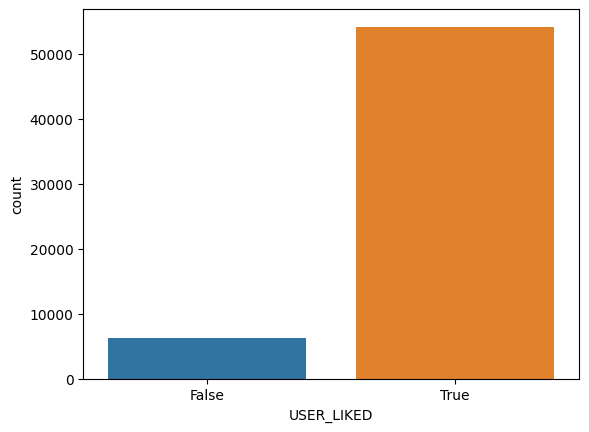

In [6]:
df_train.value_counts('USER_LIKED',sort=True).reset_index(name='count').pipe(
    lambda df:(sns.barplot(
        data=df,
        x='USER_LIKED',
        y='count'
    ))
)

Cantidad de productos que se recomiendan mas de una vez


,Producto Recomendado(B),Cantidad Producto recomendacion (A)
16,23,4
20,21,2
19,20,3
21,19,2
18,18,4
15,17,4
17,16,4
14,15,8
13,14,11
12,13,17


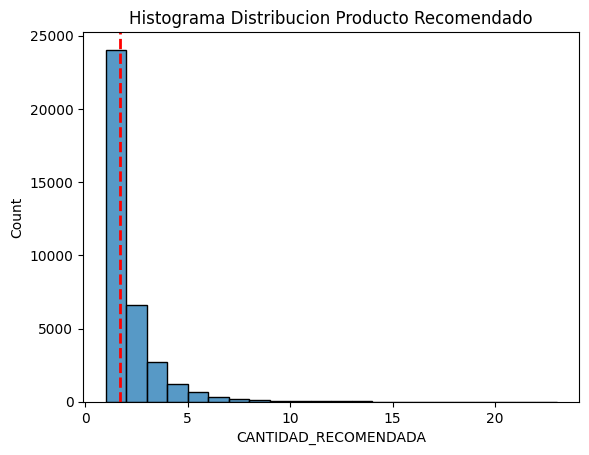

In [7]:
df_train_hist = df_train.groupby(['PRODUCT_ID',] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'CANTIDAD_RECOMENDADA': len(x['RECOMMENDED_PRODUCT_ID'].unique())
                                }))
df_train_hist= df_train_hist.reset_index()

#Distribucion de las recomendaciones
sns.histplot(
    data=df_train_hist ,
    x='CANTIDAD_RECOMENDADA',
    binwidth=1
).set_title('Histograma Distribucion Producto Recomendado')

plt.axvline(
    x =df_train_hist ['CANTIDAD_RECOMENDADA'].mean(),
    color='red',
    linestyle = 'dashed',
    linewidth = 2
)
print('Cantidad de productos que se recomiendan mas de una vez')
df_train_hist = df_train_hist['CANTIDAD_RECOMENDADA'].value_counts().reset_index()
df_train_hist = df_train_hist.rename(columns = {'CANTIDAD_RECOMENDADA':'Cantidad Producto recomendacion (A)','index': 'Producto Recomendado(B)'})
df_train_hist.sort_values(by=['Producto Recomendado(B)'], ascending=False)


# Armar un clasificador que indique si un producto es una buena recomendación similar para otro.

In [8]:
df_train_prob = df_train.groupby(['RECOMMENDED_PRODUCT_ID','USER_LIKED'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'CANTIDAD': len(x['PRODUCT_ID'].unique()),
                                    'PRODUCT_ID': sorted(x['PRODUCT_ID'].unique())
                                }))
df_train_prob = df_train_prob.reset_index()

In [9]:
df_train_prob['USER_LIKED'].unique()

probabilidad_recomendacion = (
    df_train_prob
    .assign(is_liked = lambda df : df['USER_LIKED'].replace(['True',
    'False'],[1,0]))
)
probabilidad_recomendacion['is_liked'] = probabilidad_recomendacion['is_liked'].astype(int)
probabilidad_recomendacion.head(10)

,RECOMMENDED_PRODUCT_ID,USER_LIKED,CANTIDAD,PRODUCT_ID,is_liked
0,10717,True,1,[981002037],1
1,10816,True,1,[1563463539],1
2,10818,True,1,[10816],1
3,11008,True,1,[11609],1
4,11422,True,1,[980998720],1
5,11445,True,1,[980998711],1
6,11746,True,1,[980992681],1
7,13149,True,1,[980992555],1
8,13623,True,1,[980997566],1
9,13709,True,1,[980999376],1


##### Probabilidad de cada producto segun la recomendación dada

In [10]:
probabilidad = empiricaldist.Cdf.from_seq(
    probabilidad_recomendacion['RECOMMENDED_PRODUCT_ID'],
    normalize=True
)
probabilidad = probabilidad.reset_index(name='PROB')
probabilidad = probabilidad.rename(columns = {'index':'RECOMMENDED_PRODUCT_ID_Y'})
probabilidad.head(3)

,RECOMMENDED_PRODUCT_ID_Y,PROB
0,10717,0.00
1,10816,0.00
2,10818,0.00


In [11]:
probabilidad_recomendacion = probabilidad_recomendacion.merge(probabilidad, left_on='RECOMMENDED_PRODUCT_ID',right_on='RECOMMENDED_PRODUCT_ID_Y', how='left')
probabilidad_recomendacion.head(5)

,RECOMMENDED_PRODUCT_ID,USER_LIKED,CANTIDAD,PRODUCT_ID,is_liked,RECOMMENDED_PRODUCT_ID_Y,PROB
0,10717,True,1,[981002037],1,10717,0.00
1,10816,True,1,[1563463539],1,10816,0.00
2,10818,True,1,[10816],1,10818,0.00
3,11008,True,1,[11609],1,11008,0.00
4,11422,True,1,[980998720],1,11422,0.00


In [12]:
def recomendacion(row):
    if row['PROB'] > 0 and row['PROB'] < 0.3:
        return "1. No Es Buena Recomendacion"
    elif row['PROB'] >= 0.3 and row['PROB'] < 0.5:
        return "2. Recomendacion Aceptable"
    elif row['PROB'] >= 0.5 and row['PROB'] < 0.8:
        return "3. Recomendacion Buena"
    elif row['PROB'] >= 0.8 and row['PROB'] < 1:
        return "4. Excelente recomendacion"
    else:
        return"1. No Es Buena Recomendacion"

probabilidad_recomendacion['recomendacion'] = probabilidad_recomendacion.apply(recomendacion,axis=1)

#### Una vez teniendo en cuenta el Dataset de probabilidad, filtramos los productos que no son calificados con Gusto hacia los clientes

In [13]:
probabilidad_recomendacion = probabilidad_recomendacion[probabilidad_recomendacion['is_liked'] == 1]
probabilidad_recomendacion.sample(frac= 0.00008)

,RECOMMENDED_PRODUCT_ID,USER_LIKED,CANTIDAD,PRODUCT_ID,is_liked,RECOMMENDED_PRODUCT_ID_Y,PROB,recomendacion
37575,1563522645,True,1,[975055079],1,1563522645,0.99,4. Excelente recomendacion
33755,981416201,True,1,[975159437],1,981416201,0.89,4. Excelente recomendacion
28332,980072760,True,1,[980073111],1,980072760,0.75,3. Recomendacion Buena


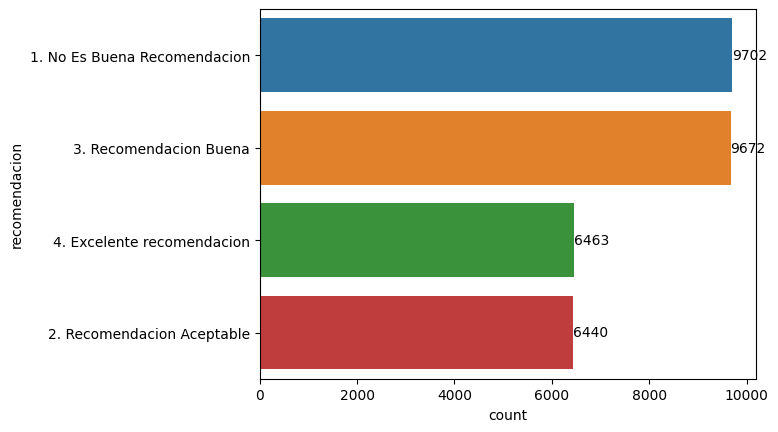

In [14]:
ax = probabilidad_recomendacion.value_counts('recomendacion',sort=True).reset_index(name='count').pipe(
    lambda df:(sns.barplot(
        data=df,
        y='recomendacion',
        x='count',
        orient = "h",
        order=df['recomendacion']
    ))
)

for i in ax.containers:
    ax.bar_label(i,)


#### OBTENEMOS LA TABLA FINAL DE PROBABILIDAD

In [15]:
probabilidad_recomendacion[probabilidad_recomendacion['RECOMMENDED_PRODUCT_ID'] == 975120970]

,RECOMMENDED_PRODUCT_ID,USER_LIKED,CANTIDAD,PRODUCT_ID,is_liked,RECOMMENDED_PRODUCT_ID_Y,PROB,recomendacion
2853,975120970,True,5,"[975123378, 975123535, 975123650, 975175902, 9...",1,975120970,0.08,1. No Es Buena Recomendacion


In [16]:
df_probabilidad = probabilidad_recomendacion.explode('PRODUCT_ID')
df_probabilidad[df_probabilidad['RECOMMENDED_PRODUCT_ID'] == 975120970]

,RECOMMENDED_PRODUCT_ID,USER_LIKED,CANTIDAD,PRODUCT_ID,is_liked,RECOMMENDED_PRODUCT_ID_Y,PROB,recomendacion
2853,975120970,True,5,975123378,1,975120970,0.08,1. No Es Buena Recomendacion
2853,975120970,True,5,975123535,1,975120970,0.08,1. No Es Buena Recomendacion
2853,975120970,True,5,975123650,1,975120970,0.08,1. No Es Buena Recomendacion
2853,975120970,True,5,975175902,1,975120970,0.08,1. No Es Buena Recomendacion
2853,975120970,True,5,976321409,1,975120970,0.08,1. No Es Buena Recomendacion


In [17]:
df_probabilidad_prod = df_probabilidad.reindex(columns = ['PRODUCT_ID','RECOMMENDED_PRODUCT_ID','recomendacion'])
df_probabilidad_prod.sample(frac= 0.0001)

,PRODUCT_ID,RECOMMENDED_PRODUCT_ID,recomendacion
9271,975231092,975228075,1. No Es Buena Recomendacion
5225,975126228,975158787,1. No Es Buena Recomendacion
16410,979239496,976229129,2. Recomendacion Aceptable
32151,981011802,981011801,4. Excelente recomendacion
24351,977732030,977741329,3. Recomendacion Buena


### Clasificador

Este clasificador funciona con un LEFT JOIN entre el product_id y el recommended_product_id

In [18]:
df_train_f_prob = df_train.merge(df_probabilidad_prod, left_on=['RECOMMENDED_PRODUCT_ID','PRODUCT_ID'],right_on=['RECOMMENDED_PRODUCT_ID','PRODUCT_ID'], how='left')
df_train_f_prob['recomendacion'] = df_train_f_prob['recomendacion'].fillna('1. No Es Buena Recomendacion')

In [19]:
df_train_f_prob['recomendacion'].value_counts().reset_index(name='Cantidad').sort_values(by=['index'], ascending=False)

,index,Cantidad
3,4. Excelente recomendacion,9910
1,3. Recomendacion Buena,15767
2,2. Recomendacion Aceptable,10762
0,1. No Es Buena Recomendacion,23991


In [20]:
df_train_f_prob.columns

Index(['Unnamed: 0', 'PRODUCT_ID', 'RECOMMENDED_PRODUCT_ID', 'USER_LIKED',
       'RECOMENDATION_INDEX_ORDER', 'RECOMMENDATION_APPROVED_BY_USER',
       'RECOMMENDATION_DONE_BY_RT', 'RECOMMENDATION_DONE_BY_USER',
       'PRODUCT_SALES', 'RECOMMENDED_PRODUCT_SALES', 'PRODUCT_CATEGORY_PATH',
       'RECOMMENDED_PRODUCT_CATEGORY_PATH', 'PRODUCT_NAME',
       'PRODUCT_LONG_DESCRIPTION', 'PRODUCT_TRADEMARK', 'PRODUCT_MAKER',
       'PRODUCT_LAST_PRICE_SOLD', 'RECOMMENDED_PRODUCT_NAME',
       'RECOMMENDED_PRODUCT_LONG_DESCRIPTION', 'RECOMMENDED_PRODUCT_TRADEMARK',
       'RECOMMENDED_PRODUCT_MAKER', 'RECOMMENDED_PRODUCT_LAST_PRICE_SOLD',
       'recomendacion'],
      dtype='object')

In [21]:
nombre = 'Takis Frituras Sabor Fuego' ## Insertar el producto a verificar
df_train_f_prob = df_train_f_prob[df_train_f_prob['PRODUCT_NAME'] == nombre].head(10)
prueba = df_train_f_prob.reindex(columns = ['recomendacion','PRODUCT_ID','PRODUCT_NAME','PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME','RECOMMENDED_PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_SALES'])
prueba

,recomendacion,PRODUCT_ID,PRODUCT_NAME,PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,RECOMMENDED_PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_SALES
682,2. Recomendacion Aceptable,975454620,Takis Frituras Sabor Fuego,Bimbo-Barcel,975459098,Bimbo-Barcel Takis Snack Sabor Original,Bimbo-Barcel,87.00
1175,3. Recomendacion Buena,977554870,Takis Frituras Sabor Fuego,Bimbo-Barcel,977145026,Chips Papas Fritas Fuego,NaN,3004.00
1515,1. No Es Buena Recomendacion,975126724,Takis Frituras Sabor Fuego,Bimbo-Barcel,975158787,Sabritas-Ruffles Papas Sabor a Queso,Sabritas-Ruffles,130.00
1807,3. Recomendacion Buena,981013460,Takis Frituras Sabor Fuego,Bimbo-Barcel,981002817,Sabritas-Rancheritos Botanas Sabor Mexicano,Sabritas-Rancheritos,170.00
2083,3. Recomendacion Buena,978774272,Takis Frituras Sabor Fuego,Bimbo-Barcel,978630940,Bimbo-Barcel Takis Sabor Original,Bimbo-Barcel,107.00
2113,1. No Es Buena Recomendacion,976229026,Takis Frituras Sabor Fuego,Bimbo-Barcel,975108105,Chips Papas Fuego Limón,NaN,80.00
2431,3. Recomendacion Buena,975454620,Takis Frituras Sabor Fuego,Bimbo-Barcel,977175112,Botana Takis Fuego 90 G,Bimbo-Barcel,364.00
3224,1. No Es Buena Recomendacion,981013461,Takis Frituras Sabor Fuego,Bimbo-Barcel,981007471,Takis Frituras Sabor Fuego,Bimbo-Barcel,328.00
3685,4. Excelente recomendacion,981013461,Takis Frituras Sabor Fuego,Bimbo-Barcel,981006653,Barcel Papas Fritas Chips Fuego,Barcel,235.00
4021,1. No Es Buena Recomendacion,976229026,Takis Frituras Sabor Fuego,Bimbo-Barcel,975106997,Paketaxo Botana Surtida Xtra Flamin Hot,Paketaxo,8.00


# Analisis - Medir (todo lo que consideres relevante)

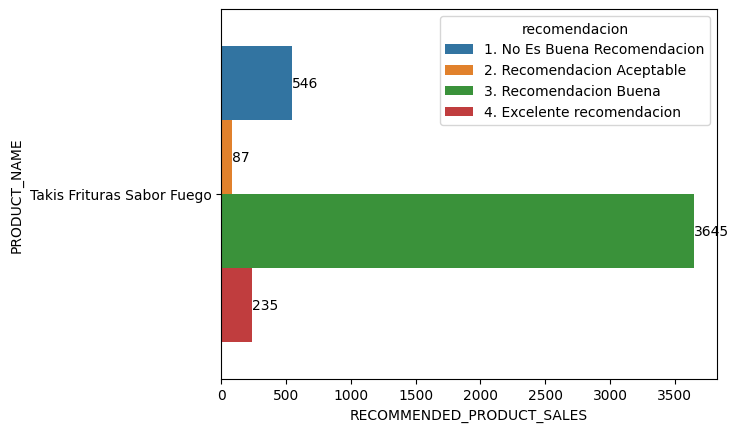

In [22]:
prueba_sns = prueba.groupby(['recomendacion','PRODUCT_NAME']).agg({'RECOMMENDED_PRODUCT_SALES':'sum'})
prueba_sns = pd.DataFrame(prueba_sns).reset_index()
ax = sns.barplot(x='RECOMMENDED_PRODUCT_SALES', y='PRODUCT_NAME', hue='recomendacion', data=prueba_sns)

for i in ax.containers:
    ax.bar_label(i,)

 ## Se puede observar que para el producto top que son los Takis Frituras Sabor Fuego, las recomendaciones dentro de él no todas son buenas, dentro de sus clasificaciones hay malas combinaciones, teniendo en cuenta que la cantidad de órdenes del producto recomendado, se encuentra en la categoría BUENA, y las excelentes tiene pocos pedidos

# Predecir para test_challengue.csv

### Hay valores Nulos en product_id, entonces se realiza un left join con la tabla de train_data para poder saber el ID de estos productos

In [23]:
df_probabilidad_prod_test = df_probabilidad_prod
df_train_products = df_train.reindex(columns = ['PRODUCT_ID','PRODUCT_NAME','RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME'])
df_train_products_prob = df_train_products.merge(df_probabilidad_prod_test, left_on=['PRODUCT_ID'], right_on=['PRODUCT_ID'], how='left')
df_test_f_prob = df_test.merge(df_train_products_prob, left_on=['PRODUCT_NAME','RECOMMENDED_PRODUCT_ID'],right_on=['PRODUCT_NAME','RECOMMENDED_PRODUCT_ID_y'], how='left')
df_test_f_prob['recomendacion'] = df_test_f_prob['recomendacion'].fillna('1. No Es Buena Recomendacion')

In [24]:
df_test_hist = df_test_f_prob.groupby(['recomendacion'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'PRODUCT_ID': len(x['PRODUCT_ID_x'].unique())
                                }))
df_test_hist= df_test_hist.reset_index()
df_test_hist

,recomendacion,PRODUCT_ID
0,1. No Es Buena Recomendacion,6043
1,2. Recomendacion Aceptable,35
2,3. Recomendacion Buena,28
3,4. Excelente recomendacion,33


In [25]:
nombre = 'Takis Frituras Sabor Fuego' ## Insertar el producto a verificar
df_test_f_prob_f = df_test_f_prob[df_test_f_prob['PRODUCT_NAME'] == nombre].head(10)
prueba_1 = df_test_f_prob_f.reindex(columns = ['recomendacion','PRODUCT_ID','PRODUCT_NAME','PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME','RECOMMENDED_PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_SALES'])
prueba_1

,recomendacion,PRODUCT_ID,PRODUCT_NAME,PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,RECOMMENDED_PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_SALES
575,1. No Es Buena Recomendacion,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976486483,NaN,Hot Nuts,583.00
618,1. No Es Buena Recomendacion,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,977148322,NaN,Maruchan,1115.00
1226,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1227,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1228,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1229,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1230,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1231,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1232,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00
1233,2. Recomendacion Aceptable,NaN,Takis Frituras Sabor Fuego,Bimbo-Barcel,976485869,NaN,Runners,916.00


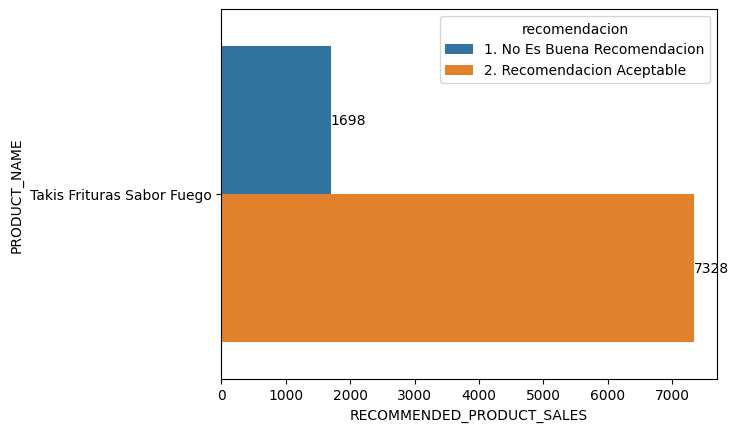

In [26]:
prueba_sns = prueba_1.groupby(['recomendacion','PRODUCT_NAME']).agg({'RECOMMENDED_PRODUCT_SALES':'sum'})
prueba_sns = pd.DataFrame(prueba_sns).reset_index()
ax = sns.barplot(x='RECOMMENDED_PRODUCT_SALES', y='PRODUCT_NAME', hue='recomendacion', data=prueba_sns)

for i in ax.containers:
    ax.bar_label(i,)

## Al realizar la misma prueba con la data de test nos podemos dar cuenta que los takis no son la mejor opción como una buena recomendación

# Algunos ejemplos de buenas recomendaciones

In [27]:
df_test_hist_ex = df_test_f_prob[df_test_f_prob['recomendacion'].str.contains('Excelente')]

df_test_hist_ex = df_test_f_prob.groupby(['PRODUCT_NAME','RECOMMENDED_PRODUCT_NAME_x'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'recomendacion': len(x['recomendacion'].unique())
                                }))
df_test_hist_ex= df_test_hist_ex.reset_index()
df_test_hist_ex.sample(frac=0.001)

,PRODUCT_NAME,RECOMMENDED_PRODUCT_NAME_x,recomendacion
2312,Graneodín F Pastillas Sabor Miel Limón,Vick Pastillas Drops Sabor Mentol,1
1824,Ensalada Oriental,Eva Ensalada Primavera,1
4983,Sabritas-Fritos Fritos Sabritas Botana Sal Y L...,Sabritas-Fritos Sabor Chile Y Limón,1
4443,Petalo Papel Higiénico Vitamina E,Suavel Papel Higiénico Jumbo Doble Hoja,1
4263,Pan Para Hamburguesa,Wonder Pan Bollos con Ajonjolí,1
4320,Parma Queso Parmesano Molido,Kraft Queso Parmesano Rallado,1


# Predecir para test_challengue.csv

In [29]:
df_test_f_prob.to_csv('test_challengue_prob.csv')
df_test_f_prob.to_excel('test_challengue_prob.xlsx')